In [8]:
from cv2 import aruco
import cv2
import numpy as np
import os
import csv
import sys
from tqdm import tqdm
from IPython.display import display, Image
import msgpack as mp
import msgpack_numpy as mpn

In [2]:
_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
_pth = os.path.join(_pth, 'ArUco_detection', "images")
image_list = os.listdir(_pth)

In [9]:
_webcam_calib_folder = r"C:\Users\CMC\Documents\openposelibs\pose\armbo\recording_programs\test_data\omni_cam_9d0f_may_8_2023\calibration_00"

_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]
_webcam_video_pth = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_timestamp_pth = os.path.join(_webcam_calib_folder, "webcam_timestamp.msgpack")

with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)
print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)

camera matrix [[880.19523452   0.         358.2789884 ]
 [  0.         881.87061144 242.70902376]
 [  0.           0.           1.        ]]
distortion [[ 1.24325941e-01 -1.20330000e-01 -2.99461015e-03 -1.15851300e-03
  -3.99283638e+00]]


In [3]:
_tmp_image = cv2.imread(os.path.join(_pth, image_list[0]))
height, width, channels = _tmp_image.shape

In [4]:
print("Image size: ", height, width, channels)

Image size:  608 750 3


In [6]:
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
markerLength = 0.05
markerSeparation = 0.01

board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=markerLength,
        markerSeparation=markerSeparation,
        dictionary=ARUCO_DICT)

Detect a ramdom image and show the rectangle

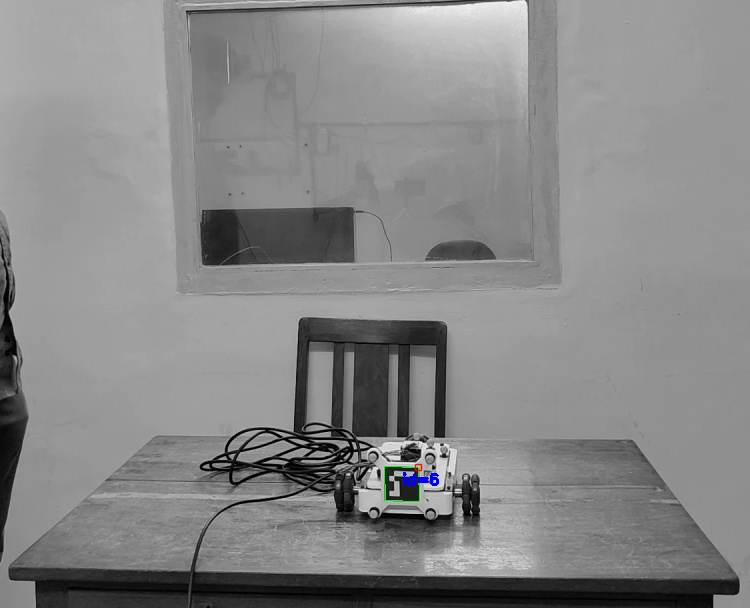

In [7]:
# draw rectangle using aruco marker
temp_image = cv2.imread(os.path.join(_pth, image_list[0]))
# get the corners of the aruco marker
corners, ids, rejected_img_points = aruco.detectMarkers(_tmp_image, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
# draw the marker and show it
temp_image = aruco.drawDetectedMarkers(temp_image, corners, ids)
display(Image(data=cv2.imencode('.jpg', temp_image)[1].tobytes()))

In [17]:
raw_data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
raw_data_pth = os.path.join(raw_data_pth, 'dataset', "raw_data")
if not os.path.exists(raw_data_pth):
    os.makedirs(os.path.join(raw_data_pth, "images"))
    os.makedirs(os.path.join(raw_data_pth, "labels"))

In [18]:
for img_name in tqdm(image_list):
    _image_path = os.path.join(_pth, img_name)
    image = cv2.imread(_image_path)

    markerCorners, markerIds, rejected_img_points = aruco.detectMarkers(image, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
    markerCorners, markerIds, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
            image = image,
            board = board,
            detectedCorners = corners,
            detectedIds = ids,
            rejectedCorners = rejected_img_points,
            cameraMatrix = _webcam_cam_mat,
            distCoeffs = _webcam_dist)
    
    if len(markerCorners) == 0:
        continue
    
    label_name = img_name.split(".")[0]
    label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
    label_file = open(label_path, "w")
    label_writer = csv.writer(label_file, delimiter=" ")
    _markerCorners = markerCorners[0][0]

    bbox_x,bbox_y,bbox_width,bbox_height = cv2.boundingRect(_markerCorners)

    # normalize the values
    bbox_x = bbox_x / width
    bbox_y = bbox_y / height

    bbox_center_x = bbox_x + bbox_width / (2 * width)
    bbox_center_y = bbox_y + bbox_height / (2 * height)

    bbox_width = bbox_width / width
    bbox_height = bbox_height / height

    label_writer.writerow(["0", bbox_center_x, bbox_center_y, bbox_width, bbox_height,_markerCorners[0][0]/width, _markerCorners[0][1]/height, _markerCorners[1][0]/width, _markerCorners[1][1]/height, _markerCorners[2][0]/width, _markerCorners[2][1]/height, _markerCorners[3][0]/width, _markerCorners[3][1]/height, _markerCorners[0][0]/width, _markerCorners[0][1]/height])

    label_file.close()
    
    # save image
    image_path = os.path.join(raw_data_pth, "images", img_name)
    cv2.imwrite(image_path, image)


100%|██████████| 1963/1963 [01:21<00:00, 24.04it/s]


In [ ]:
# adding noise to the images

In [19]:
print(len(os.listdir(os.path.join(raw_data_pth, "labels"))), len(image_list))

1835 1963


Splitting it into traning and testing dataset

In [20]:
# splitting dataset into train and validation and test
data_pth = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_pth = os.path.join(data_pth, 'dataset', "dataset_processed")

images_pth = os.path.join(data_pth, "images")
labels_pth = os.path.join(data_pth, "labels")

if not os.path.exists(images_pth):
    os.makedirs(os.path.join(images_pth, "train"))
    os.makedirs(os.path.join(images_pth, "val"))
    os.makedirs(os.path.join(images_pth, "test"))

if not os.path.exists(labels_pth):
    os.makedirs(os.path.join(labels_pth, "train"))
    os.makedirs(os.path.join(labels_pth, "val"))
    os.makedirs(os.path.join(labels_pth, "test"))
    
    
image_list = os.listdir(os.path.join(raw_data_pth, "images"))

# splitting dataset into train and test
for img_name in tqdm(image_list):
    
    _image_path = os.path.join(raw_data_pth, "images", img_name)
    image = cv2.imread(_image_path)
    
    label_name = img_name.split(".")[0]
    label_path = os.path.join(raw_data_pth, "labels", f"{label_name}.txt")
    label_file = open(label_path, "r")
    label_reader = csv.reader(label_file, delimiter=" ")
    label = list(label_reader)[0]
    label_file.close()
    
    if int(label[0]) == 0:
        if np.random.rand() < 0.7:
            # save image
            image_path = os.path.join(os.path.join(images_pth, "train"), img_name)
            cv2.imwrite(image_path, image)
            
            label_path = os.path.join(os.path.join(labels_pth, "train"), f"{label_name}.txt")
            label_file = open(label_path, "w")
            label_writer = csv.writer(label_file, delimiter=" ")
            label_writer.writerow(label)
            label_file.close()
            
        elif np.random.rand() < 0.9 and np.random.rand() > 0.7:
            # save image
            image_path = os.path.join(os.path.join(images_pth, "val"), img_name)
            cv2.imwrite(image_path, image)
            
            label_path = os.path.join(os.path.join(labels_pth, "val"), f"{label_name}.txt")
            label_file = open(label_path, "w")
            label_writer = csv.writer(label_file, delimiter=" ")
            label_writer.writerow(label)
            label_file.close()
            
        else:
            # save image
            image_path = os.path.join(os.path.join(images_pth, "test"), img_name)
            cv2.imwrite(image_path, image)
            
            label_path = os.path.join(os.path.join(labels_pth, "test"), f"{label_name}.txt")
            label_file = open(label_path, "w")
            label_writer = csv.writer(label_file, delimiter=" ")
            label_writer.writerow(label)
            label_file.close() 


100%|██████████| 1835/1835 [01:12<00:00, 25.21it/s]
